In [1]:
import numpy as np
import casadi as ca
import pinocchio as pin
import pinocchio.casadi as cpin
import example_robot_data 
from scipy.linalg import qr

np.set_printoptions(suppress=True, threshold=np.inf, linewidth=400, precision=5)

robot = example_robot_data.load("b1_leg_FL")
model = robot.model
data = model.createData()
visual_model = robot.visual_model
collision_model = robot.collision_model
cmodel = cpin.Model(model)
cdata = cmodel.createData()
# q0 = model.referenceConfigurations["arm_up"]
q0 = robot.q0

collision_info = []
for geom_obj in collision_model.geometryObjects:
    geom = geom_obj.geometry
    if hasattr(geom, "radius") and hasattr(geom, "halfLength"):
        radius = geom.radius * 0.8
        length = geom.halfLength * 0.4
        size = np.array([2 * radius, 2 * radius, 2 * length])

        rel_placement = geom_obj.placement.copy()
        rel_placement_sym = cpin.SE3(
            ca.SX(rel_placement.rotation),
            ca.SX(rel_placement.translation)
        )
        joint_id = geom_obj.parentJoint  # for use with data.oMi

        collision_info.append({
            "joint_id": joint_id,
            "rel_placement": rel_placement,
            "rel_placement_sym": rel_placement_sym,
            "size": size,
            "name": geom_obj.name
        })

def max_linearly_independent_columns(matrix, tol=1e-10):
    _, S, Vt = np.linalg.svd(matrix)
    rank = np.sum(S > tol)
    independent_columns = np.abs(Vt[:rank, :]).T
    return np.where(np.any(independent_columns > tol, axis=1))[0]

Y_row = pin.computeJointTorqueRegressor(model, data, np.random.rand(model.nq), np.random.rand(model.nv), np.random.rand(model.nv))
ind_ind = max_linearly_independent_columns(Y_row)
print("ind_ind : ", ind_ind)

L = 10  # Order of Fourier series
T = 10.0  # Trajectory duration (s)
N = 1001  # Number of samples
# f_max = (N - 1) / (2 * T)  # Nyquist frequency
# f_b = f_max / L
f_max = 0.06
omega_f = 2 * np.pi * f_max

nq = model.nq  # Number of joints
nv = model.nv  # Number of degrees of freedom
q_min = model.lowerPositionLimit.copy()   # Minimum joint positions
q_max = model.upperPositionLimit.copy()   # Maximum joint positions
q_min[0] = -0.3
q_max[0] = 0.3
q_min[1] = -0.9
q_max[1] = 3.4
q_min[2] = -2.5
q_max[2] = -0.7
dq_min = -model.velocityLimit      # Minimum joint velocities
dq_max = model.velocityLimit       # Maximum joint velocities
tau_min = -model.effortLimit       # Minimum joint torques
tau_max = model.effortLimit        # Maximum joint torques

print("base frequency: ", f_max)
print("minimum configuration hard :", model.lowerPositionLimit)
print("maximum configuration hard :", model.upperPositionLimit)
print("minimum configuration:", q_min)
print("maximum configuration:", q_max)
print("minimum velocity:     ", dq_min)
print("maximum velocity:     ", dq_max)
print("minimum torque:       ", tau_min)
print("maximum torque:       ", tau_max)

ind_ind :  [ 2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
base frequency:  0.06
minimum configuration hard : [-0.75 -1.   -2.6 ]
maximum configuration hard : [ 0.75  3.5  -0.6 ]
minimum configuration: [-0.3 -0.9 -2.5]
maximum configuration: [ 0.3  3.4 -0.7]
minimum velocity:      [-19.69 -23.32 -15.55]
maximum velocity:      [19.69 23.32 15.55]
minimum torque:        [ -91.0035  -93.33   -140.    ]
maximum torque:        [ 91.0035  93.33   140.    ]


In [2]:
a = ca.SX.sym('a', nv * L)  # Cosine coefficients
b = ca.SX.sym('b', nv * L)  # Sine coefficients
vars = ca.vertcat(ca.vec(a), ca.vec(b))

# Define the trajectory using Fourier series (Equation 9b)
# def fourier_trajectory(a, b):
#     q = ca.SX.zeros(nq, N)
#     dq = ca.SX.zeros(nq, N)
#     ddq = ca.SX.zeros(nq, N)
#     tau = ca.SX.zeros(nv, N)
#     t = np.linspace(0, T, N)
#     for j in range(N):  # time steps
#         for i in range(nq):  # joints
#             q[i, j] = q0[i]
#             for l in range(1, L + 1):  # Fourier terms
#                 omega_l = omega_f * l
#                 idx = i * L + (l - 1) 
#                 q[i, j] += (a[idx] / omega_l) * ca.sin(omega_l * t[j]) - (b[idx] / omega_l) * ca.cos(omega_l * t[j])
#                 dq[i, j] += a[idx] * ca.cos(omega_l * t[j]) + b[idx] * ca.sin(omega_l * t[j])
#                 ddq[i, j] += -a[idx] * omega_l * ca.sin(omega_l * t[j]) + b[idx] * omega_l * ca.cos(omega_l * t[j])
#             tau[:, j] = cpin.rnea(cmodel, cdata, q[:, j], dq[:, j], ddq[:, j])
#     return q, dq, ddq, tau

#chatgpt 
def fourier_trajectory(a, b):
    q = ca.SX.zeros(nq, N)
    dq = ca.SX.zeros(nv, N)
    ddq = ca.SX.zeros(nv, N)
    tau = ca.SX.zeros(nv, N)
    t = np.linspace(0, T, N)
    q0_ = ca.SX(q0)
    for j in range(N):  # time steps
        delta_q = ca.SX.zeros(nv)
        for i in range(nv):  # tangent space dimension
            for l in range(1, L + 1):
                omega_l = omega_f * l
                idx = i * L + (l - 1)
                sin_term = ca.sin(omega_l * t[j])
                cos_term = ca.cos(omega_l * t[j])

                delta_q[i] += (a[idx] / omega_l) * sin_term - (b[idx] / omega_l) * cos_term
                dq[i, j] += a[idx] * cos_term + b[idx] * sin_term
                ddq[i, j] += -a[idx] * omega_l * sin_term + b[idx] * omega_l * cos_term

        # Manifold integration for configuration
        q[:, j] = cpin.integrate(cmodel, q0_, delta_q)
        tau[:, j] = cpin.rnea(cmodel, cdata, q[:, j], dq[:, j], ddq[:, j])

    return q, dq, ddq, tau

In [3]:
q, dq, ddq, tau = fourier_trajectory(a, b)

def compute_self_collision_cost(cmodel, cdata, collision_info, q):
    cost = ca.SX(0.0)

    cpin.forwardKinematics(cmodel, cdata, q)
    cpin.updateFramePlacements(cmodel, cdata)

    placements = []
    for obj in collision_info:
        joint_id = obj["joint_id"]
        rel_placement = obj["rel_placement_sym"]
        joint_placement = cdata.oMi[joint_id]
        placement = joint_placement.act(rel_placement)
        placements.append(placement)

    for i in range(len(placements)):
        for j in range(i + 1, len(placements)):
            pi = placements[i].translation
            pj = placements[j].translation
            di = collision_info[i]["size"] / 2.0
            dj = collision_info[j]["size"] / 2.0

            ri = ca.norm_2(di)
            rj = ca.norm_2(dj)
            dist = ca.norm_2(pi - pj)
            collision_margin = 0.01  # meters
            penetration = ca.fmax(0, ri + rj - dist - collision_margin)
            cost += penetration**2

    return cost

def cost_func(q, dq, ddq):
    Yb = []
    collision_cost = ca.SX(0)
    for j in range(N):
        Y_row = cpin.computeJointTorqueRegressor(cmodel, cdata, q[:, j], dq[:, j], ddq[:, j])
        Yb.append(Y_row)
        # collision_cost += compute_self_collision_cost(cmodel, cdata, collision_info, q[:, j])
    Yb = ca.vertcat(*Yb)
    Y_b = Yb

    # Base cost from regressor
    r_c_sym = (0.5 * (ca.norm_fro(Y_b)**2)) + ((1 / (nv * 2)) * (ca.norm_fro(Y_b)**2))
    # maximize joint velocitiesç
    r_c_sym -= ca.sum2(ca.sum1(dq[0, 1:-1]**2)) * 1e3
    r_c_sym -= ca.sum2(ca.sum1(dq[1:, 1:-1]**2)) * 1e1
    # penalize self-collision
    r_c_sym += collision_cost * 1e10

    return r_c_sym


# Constraints
constraints = []
lbg = []
ubg = []

# intial and final conditions
for j in range(nq):
    constraints += [q[j, 0]]
    lbg += [q0[j]]
    ubg += [q0[j]]
    constraints += [q[j, -1]]
    lbg += [q0[j]]
    ubg += [q0[j]]
for j in range(nv):
    constraints += [dq[j, 0], ddq[j, 0]]
    lbg += [0, 0]
    ubg += [0, 0]
    constraints += [dq[j, -1], ddq[j, -1]]
    lbg += [0, 0]
    ubg += [0, 0]

# Constraints on joint positions and velocities
for j in range(1,N-1):
    for i in range(nq):
        constraints += [q[i, j]]
        lbg += [q_min[i]]
        ubg += [q_max[i]]
    for i in range(nv):
        constraints += [dq[i, j]]
        lbg += [dq_min[i]]
        ubg += [dq_max[i]]


# joint torque limits
# for j in range(1,N-1):
#     for i in range(nv):
#         constraints += [tau[i, j]]
#         lbg += [tau_min[i]]
#         ubg += [tau_max[i]]

In [4]:

nlp = {'x': vars, 'f': cost_func(q, dq, ddq), 'g': ca.vertcat(*constraints)}

# Create solver
opts = {
    'ipopt': {
        'max_iter': 500,
    }
}
solver = ca.nlpsol('solver', 'ipopt', nlp, opts)
# Generate initial guesses
b_init = np.ones(nv* L)
a_init = np.ones(nv* L)

# Reshape for joint-wise interpretation
a_init_reshaped = a_init.reshape(nv, L)
b_init_reshaped = b_init.reshape(nv, L)

print("a_init (per joint):")
for i in range(nv):
    print(f"Joint {i}: {a_init_reshaped[i, :]}")

print("\nb_init (per joint):")
for i in range(nv):
    print(f"Joint {i}: {b_init_reshaped[i, :]}")
vars_init = np.concatenate([a_init.flatten(), b_init.flatten()])

a_init (per joint):
Joint 0: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Joint 1: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Joint 2: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

b_init (per joint):
Joint 0: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Joint 1: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Joint 2: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
sol = solver(x0=vars_init, lbg=lbg, ubg=ubg)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      270
Number of nonzeros in inequality constraint Jacobian.:   119880
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       18
Total number of inequality c

In [6]:
# Extract solution
# Assuming nv, L, and sol are defined
a_opt = np.reshape(np.array(sol['x'][:nv * L]), (nv, L))
b_opt = np.reshape(np.array(sol['x'][nv * L:]), (nv, L))

print("a_opt (per joint):")
for i in range(nv):
    print(f"Joint {i}: {a_opt[i, :]}")

print("\nb_opt (per joint):")
for i in range(nv):
    print(f"Joint {i}: {b_opt[i, :]}")

a_opt (per joint):
Joint 0: [  0.21336   3.47624  -2.48158 -14.71546  -0.69424  19.88867   7.82412  -9.45963  -5.3725    1.32101]
Joint 1: [  2.40093 -21.92778 -32.86905  28.86448  56.44463  -0.4067  -30.57734  -7.92769   4.80707   1.19143]
Joint 2: [-0.33914  1.89485  4.94664 -0.08023 -6.21972 -3.82158  1.22603  2.12874  0.33816 -0.07376]

b_opt (per joint):
Joint 0: [  0.75919  -1.27115  -8.52205   2.12036  19.35471   4.84044 -15.84519  -7.81734   4.02636   3.02693]
Joint 1: [ -6.95718 -13.47823  31.91653  50.71029 -13.82407 -47.65745  -7.72863  14.57735   4.30229  -1.08511]
Joint 2: [ 0.75279  2.25773 -1.74049 -6.64609 -3.91789  3.97773  3.62864  0.18387 -0.69149  0.16127]


Condition number of the trajectory: 1.1118107772212749e+17


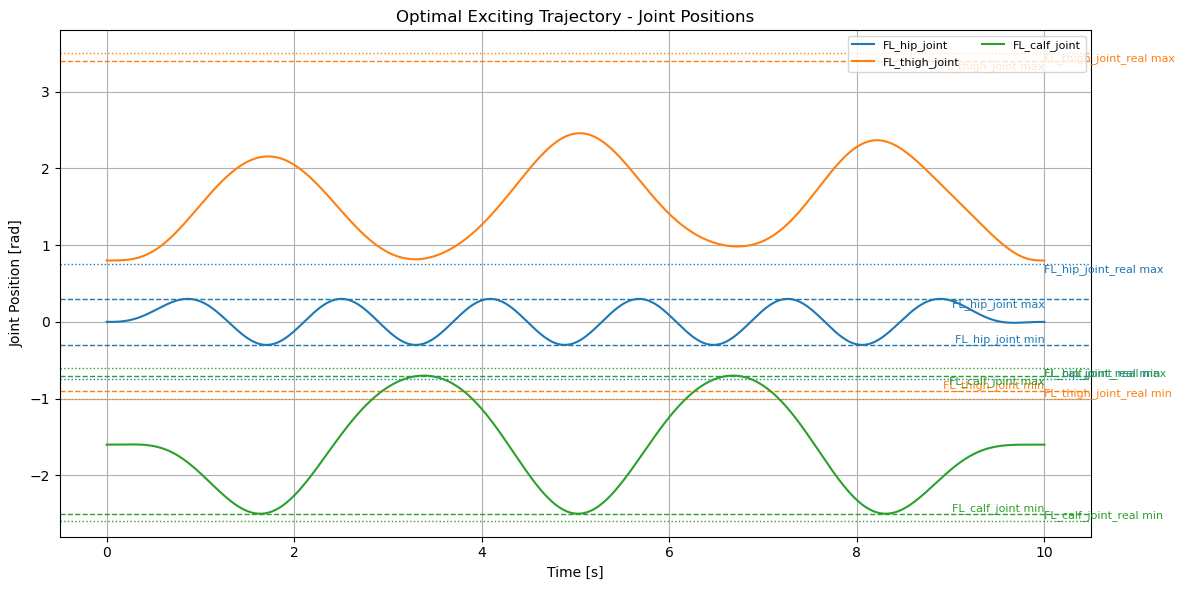

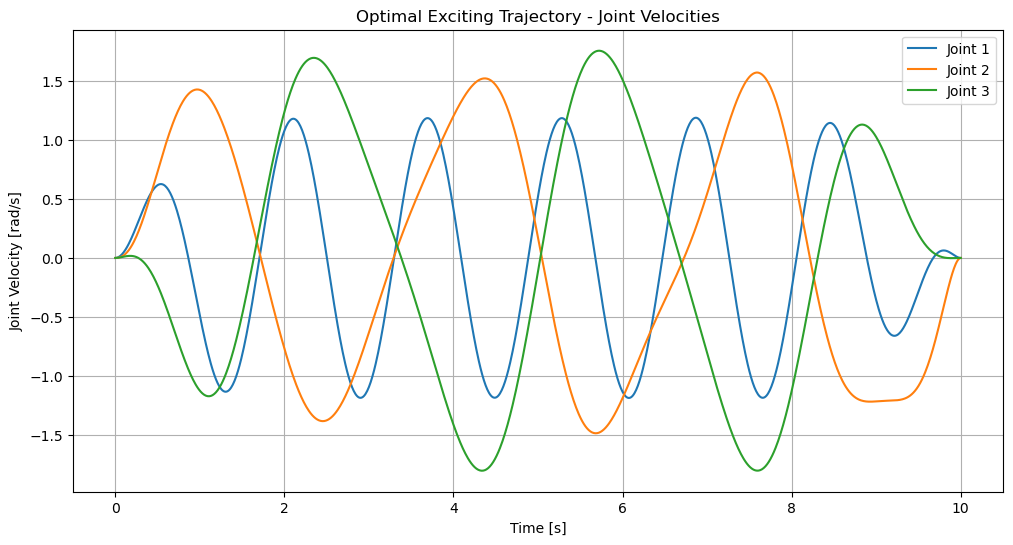

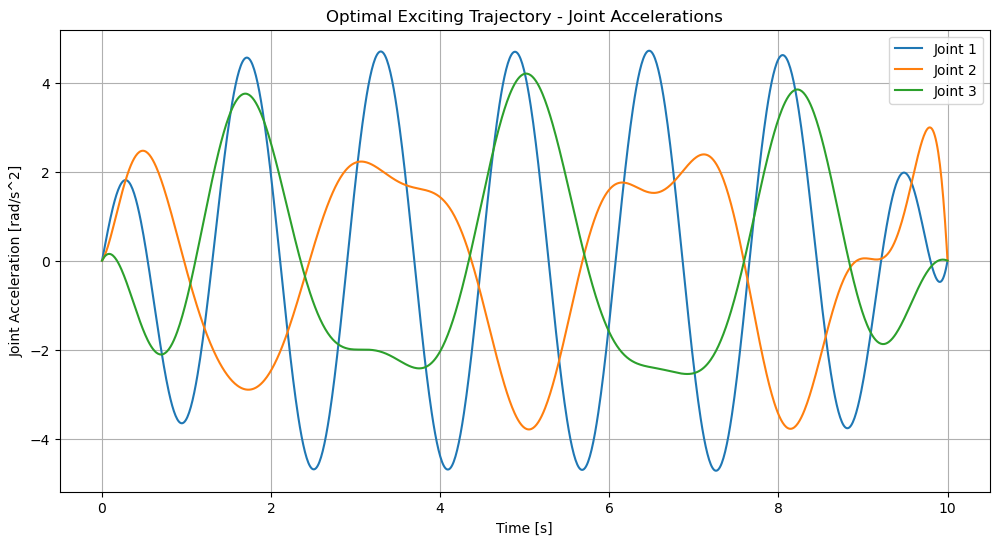

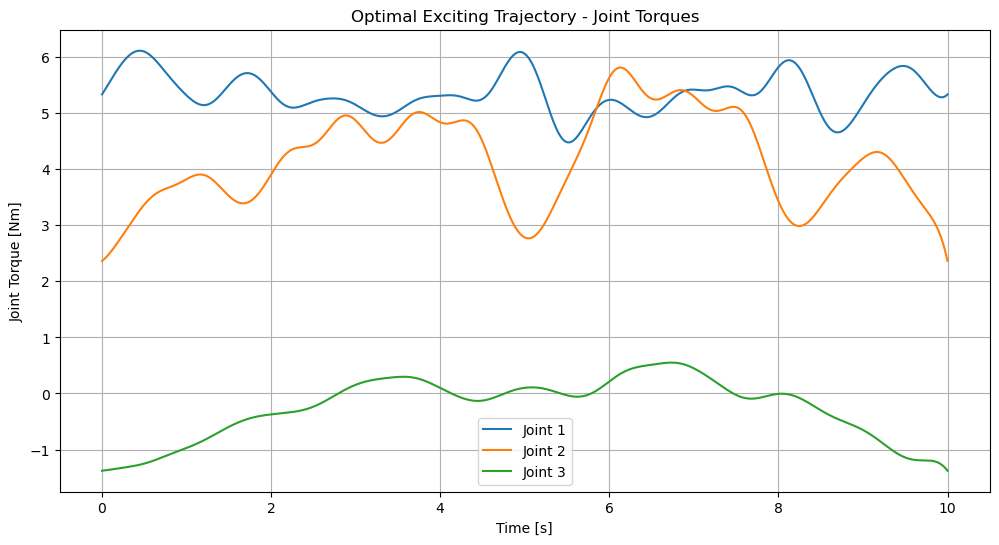

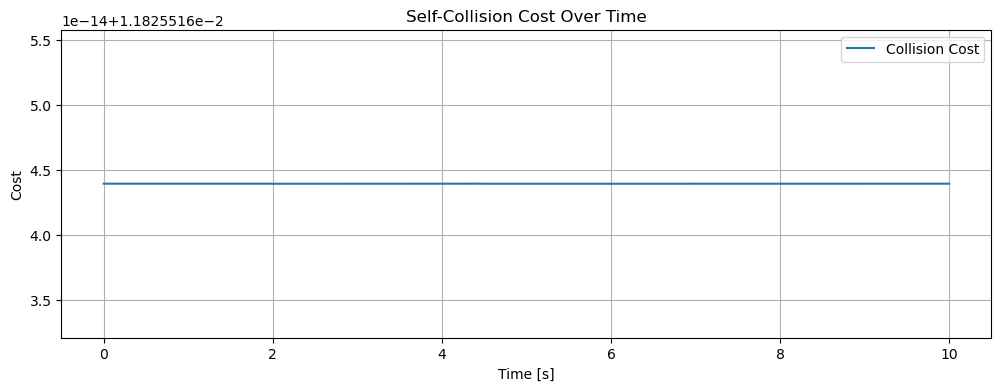

In [7]:
# Generate the optimal trajectory

a_opt = np.reshape(np.array(sol['x'][:nv*L]), (nv* L))
b_opt = np.reshape(np.array(sol['x'][nv*L:]), (nv* L))
q_traj, dq_traj, ddq_traj, tau_traj = fourier_trajectory(a_opt, b_opt)
# q_traj, dq_traj, ddq_traj = bspline_trajectory(a_opt, b_opt, q0=q0, nq=nq, L=L, N=N, T=T, order=5)

# Convert CasADi symbolic expressions to numpy arrays
q_traj_np = np.array([ca.DM(q).full().flatten() for q in ca.horzsplit(q_traj)])
dq_traj_np = np.array([ca.DM(dq).full().flatten() for dq in ca.horzsplit(dq_traj)])
ddq_traj_np = np.array([ca.DM(ddq).full().flatten() for ddq in ca.horzsplit(ddq_traj)])
tau_traj = np.array([ca.DM(tau).full().flatten() for tau in ca.horzsplit(tau_traj)])

# compute the conditional number of the trajectory
Yb = np.zeros((N*nv, len(ind_ind)))
for i, (q, dq, ddq)in enumerate(zip(q_traj_np, dq_traj_np, ddq_traj_np)):
    Y_row = pin.computeJointTorqueRegressor(model, data, q, dq, ddq)
    Yb[ i*nv : ((1+i)*nv),:] = Y_row[:, ind_ind]
Yb = np.linalg.cond(Yb)
print("Condition number of the trajectory:", Yb)

t = np.linspace(0, T, N)

# Plot the results (optional)
import matplotlib.pyplot as plt

# Plot joint positions
plt.figure(figsize=(12, 6))
for j in range(nq):
    # Plot the joint trajectory and store its color
    line, = plt.plot(t, q_traj_np[:, j], label=f'{model.names[j+1]}')
    color = line.get_color()
    # --- Nominal limits ---
    plt.axhline(y=q_min[j], color=color, linestyle='--', linewidth=1.0)
    plt.axhline(y=q_max[j], color=color, linestyle='--', linewidth=1.0)
    # --- Real limits ---
    plt.axhline(y=model.lowerPositionLimit[j], color=color, linestyle=':', linewidth=1.0)
    plt.axhline(y=model.upperPositionLimit[j], color=color, linestyle=':', linewidth=1.0)
    # --- Labels (right side) ---
    plt.text(t[-1], q_min[j], f'{model.names[j+1]} min', color=color, fontsize=8, va='bottom', ha='right')
    plt.text(t[-1], q_max[j], f'{model.names[j+1]} max', color=color, fontsize=8, va='top', ha='right')
    plt.text(t[-1], model.lowerPositionLimit[j], f'{model.names[j+1]}_real min', color=color, fontsize=8, va='bottom', ha='left')
    plt.text(t[-1], model.upperPositionLimit[j], f'{model.names[j+1]}_real max', color=color, fontsize=8, va='top', ha='left')
plt.xlabel('Time [s]')
plt.ylabel('Joint Position [rad]')
plt.title('Optimal Exciting Trajectory - Joint Positions')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot joint velocities
plt.figure(figsize=(12, 6))
for j in range(nv):
    plt.plot(t, dq_traj_np[:, j], label=f'Joint {j+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Velocity [rad/s]')
plt.title('Optimal Exciting Trajectory - Joint Velocities')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint accelerations
plt.figure(figsize=(12, 6))
for j in range(nv):
    plt.plot(t, ddq_traj_np[:, j], label=f'Joint {j+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Acceleration [rad/s^2]')
plt.title('Optimal Exciting Trajectory - Joint Accelerations')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint torques
plt.figure(figsize=(12, 6))
for j in range(nv):
    plt.plot(t, tau_traj[:, j], label=f'Joint {j+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Torque [Nm]')
plt.title('Optimal Exciting Trajectory - Joint Torques')
plt.legend()
plt.grid(True)
plt.show()

# Create symbolic input
q_sym = ca.SX.sym("q", nq)
collision_cost_sym = compute_self_collision_cost(cmodel, cdata, collision_info, q_sym)

# Wrap it in a CasADi function
collision_cost_fun = ca.Function("collision_cost", [q_sym], [collision_cost_sym])

collision_costs = np.array([
    float(collision_cost_fun(q)) for q in q_traj_np
])
plt.figure(figsize=(12, 4))
plt.plot(t, collision_costs, label="Collision Cost")
plt.xlabel("Time [s]")
plt.ylabel("Cost")
plt.title("Self-Collision Cost Over Time")
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# import meshcat
# import meshcat.geometry as g
# import meshcat.transformations as tf
# from pinocchio.visualize import MeshcatVisualizer

# # Create visualizer
# viz = MeshcatVisualizer(model, collision_model, visual_model)
# viz.initViewer(open=True)
# viz.loadViewerModel()

# def plot_geometry_box(viz, placement, name, geom):
#     # Default color material
#     mat = g.MeshLambertMaterial(color=[0.2, 0.6, 0.8], opacity=0.6, reflectivity=0.6)

#     # Approximate cylinder as a box: width = 2*radius, height = length
#     if hasattr(geom, "radius") and hasattr(geom, "halfLength"):
#         radius = geom.radius * 0.55
#         length = geom.halfLength * 0.5
#         size = [2 * radius, 2 * radius, 2 * length]
#         viz.viewer[name].set_object(g.Ellipsoid(size), mat)
#         viz.viewer[name].set_transform(placement.homogeneous)
#     else:
#         print(f"Unsupported geometry: {geom}")

# # Play the trajectory
# import time

# print("Displaying trajectory in MeshCat...")
# while True:
#     for q in q_traj_np:
#         pin.forwardKinematics(model, data, q)
#         pin.updateGeometryPlacements(model, data, robot.collision_model, robot.collision_data)
#         for i, geom_obj in enumerate(collision_model.geometryObjects):
#             placement = robot.collision_data.oMg[i]
#             geom = geom_obj.geometry
#             plot_geometry_box(
#                 viz,
#                 placement,
#                 f"collision_boxes/{geom_obj.name}",
#                 geom,
#             )
#         viz.display(q)
#         time.sleep(T / N)  # Slow down playback (optional)

In [9]:
import time
import meshcat.geometry as g
from pinocchio.visualize import MeshcatVisualizer

# Create visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)
viz.initViewer(open=True)
viz.loadViewerModel()

def plot_geometry_box_from_info(viz, placement, name, size):
    mat = g.MeshLambertMaterial(color=[0.2, 0.6, 0.8], opacity=0.6, reflectivity=0.6)
    viz.viewer[name].set_object(g.Ellipsoid(size), mat)
    viz.viewer[name].set_transform(placement.homogeneous)

print("Displaying trajectory in MeshCat...")
while True:
    for q in q_traj_np:
        pin.forwardKinematics(model, data, q)
        pin.updateFramePlacements(model, data)
        
        for obj in collision_info:
            joint_id = obj["joint_id"]
            rel_placement = obj["rel_placement"]
            size = obj["size"]

            joint_placement = data.oMi[joint_id]
            placement = joint_placement.act(rel_placement)

            plot_geometry_box_from_info(
                viz,
                placement,
                f"collision_boxes/{obj['name']}",
                size,
            )

        viz.display(q)
        time.sleep(T / N)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7052/static/
Displaying trajectory in MeshCat...


KeyboardInterrupt: 

In [10]:
def fourier_trajectory_lin(vars):
    a = vars[:nv * L]
    b = vars[nv * L:]

    q = ca.SX.zeros(nq * N)
    dq = ca.SX.zeros(nv * N)
    ddq = ca.SX.zeros(nv * N)
    tau = ca.SX.zeros(nv * N)
    t = np.linspace(0, T, N)
    q0_ = ca.SX(q0)

    for j in range(N):
        delta_q = ca.SX.zeros(nv)
        dq_j = ca.SX.zeros(nv)
        ddq_j = ca.SX.zeros(nv)

        for i in range(nv):
            for l in range(1, L + 1):
                omega_l = omega_f * l
                idx = i * L + (l - 1)
                angle = omega_l * t[j]
                sin_term = ca.sin(angle)
                cos_term = ca.cos(angle)

                delta_q[i] += (a[idx] / omega_l) * sin_term - (b[idx] / omega_l) * cos_term
                dq_j[i] += a[idx] * cos_term + b[idx] * sin_term
                ddq_j[i] += -a[idx] * omega_l * sin_term + b[idx] * omega_l * cos_term

        q_j = cpin.integrate(cmodel, q0_, delta_q)
        tau_j = cpin.rnea(cmodel, cdata, q_j, dq_j, ddq_j)

        q[j * nq:(j + 1) * nq] = q_j
        dq[j * nv:(j + 1) * nv] = dq_j
        ddq[j * nv:(j + 1) * nv] = ddq_j
        tau[j * nv:(j + 1) * nv] = tau_j

    return q, dq, ddq, tau 

In [11]:
vars_val = np.random.rand(2 * nv * L)
a_val = vars_val[:nv * L]
b_val = vars_val[nv * L:]

# Evaluate both functions symbolically
a = ca.SX.sym("a", nv * L)
b = ca.SX.sym("b", nv * L)
vars = ca.SX.sym("vars", 2 * nv * L)

# Define function handles
traj1 = ca.Function("traj1", [a, b], fourier_trajectory(a, b))
traj2 = ca.Function("traj2", [vars], fourier_trajectory_lin(vars))

# Evaluate numerically
out1 = traj1(a_val, b_val)
out2 = traj2(vars_val)

# Compare outputs
names = ["q", "dq", "ddq", "tau"]
# for k in range(4):
#     print(out1[k].shape)
#     print(out2[k].shape)
#     print()
#     diff = ca.norm_2(ca.vec(out1[k]) - out2[k])
#     print(f"Difference in {names[k]}: {diff}")

names = ["q", "dq", "ddq", "tau"]
dims = [nq, nv, nv, nv]
for k in range(4):
    dim = dims[k]
    out1_mat = out1[k]  # shape: (dim, N)
    out2_mat = ca.reshape(out2[k], dim, N)  # reshape flat to (dim, N)
    
    print(f"{names[k]} shape comparison:")
    print("out1:", out1_mat.shape)
    print("out2:", out2_mat.shape)
    print()
    print(out1_mat[:, 0])
    print(out2_mat[:, 0])
    diff = ca.norm_fro(out1_mat - out2_mat)
    print(f"Difference in {names[k]}: {diff}\n")

q shape comparison:
out1: (3, 1001)
out2: (3, 1001)

[-5.75961, -4.21862, -6.39741]
[-5.75961, -4.21862, -6.39741]
Difference in q: 0

dq shape comparison:
out1: (3, 1001)
out2: (3, 1001)

[4.60574, 3.72273, 4.46868]
[4.60574, 3.72273, 4.46868]
Difference in dq: 0

ddq shape comparison:
out1: (3, 1001)
out2: (3, 1001)

[15.2829, 11.024, 9.33027]
[15.2829, 11.024, 9.33027]
Difference in ddq: 0

tau shape comparison:
out1: (3, 1001)
out2: (3, 1001)

[11.8684, 9.44278, 2.60499]
[11.8684, 9.44278, 2.60499]
Difference in tau: 0



Condition number of the trajectory: 1.1118107772212749e+17


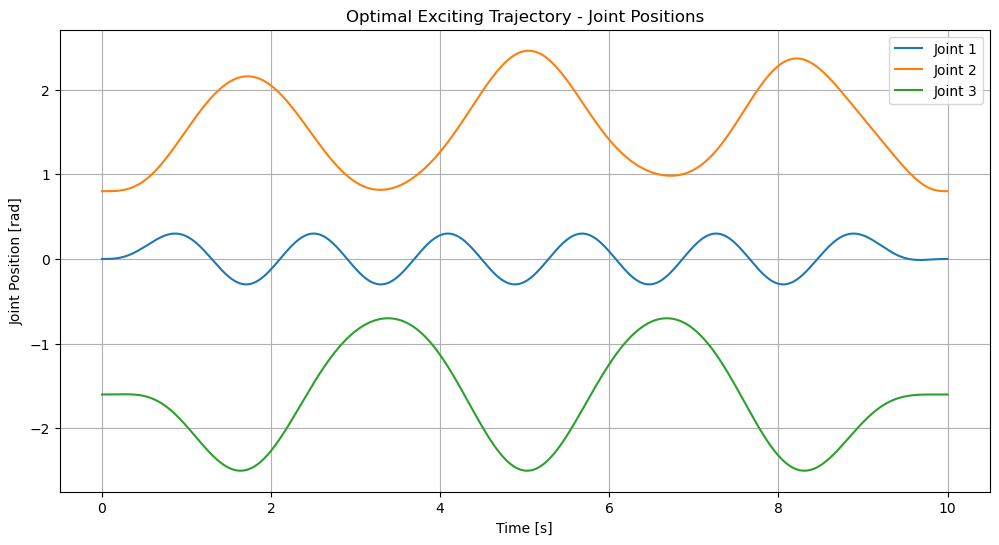

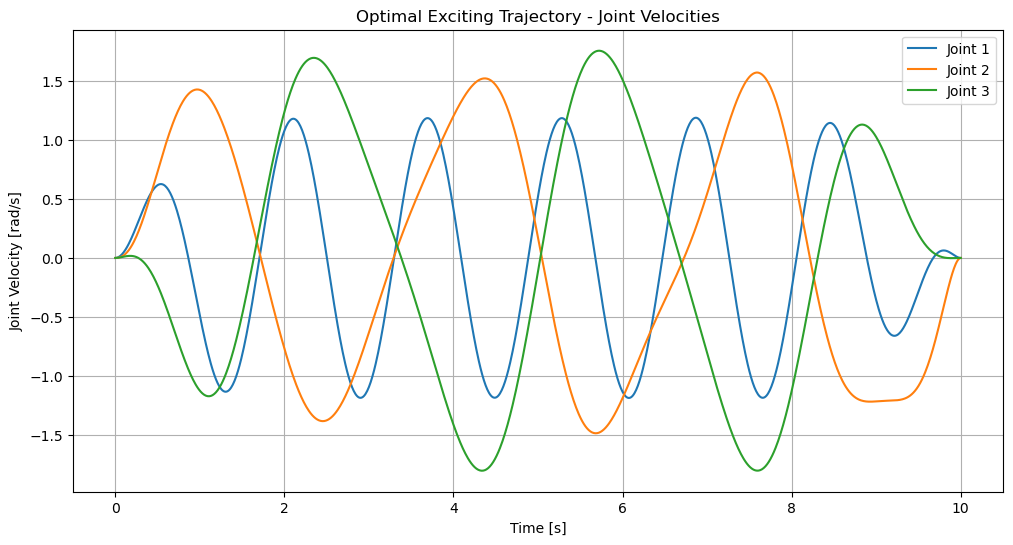

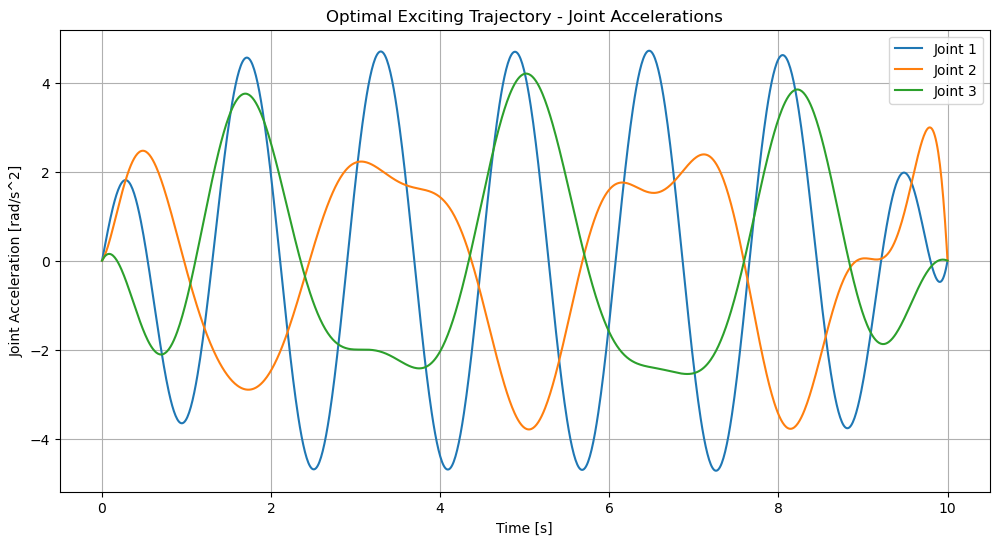

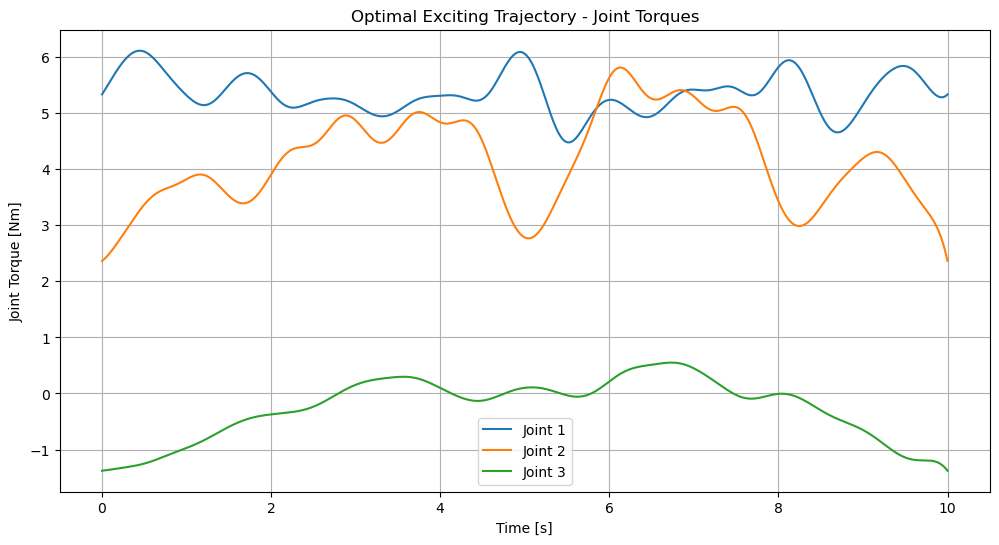

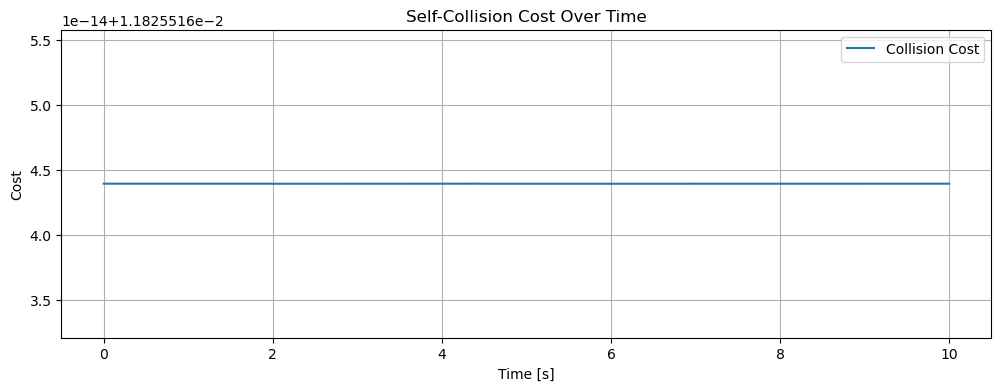

In [12]:
# Concatenate the optimal parameters into a single vector
a_opt = np.reshape(np.array(sol['x'][:nv*L]), (nv*L,))
b_opt = np.reshape(np.array(sol['x'][nv*L:]), (nv*L,))
vars_opt = np.concatenate([a_opt, b_opt])

# Build CasADi function for evaluation
vars_sym = ca.SX.sym("vars", 2 * nv * L)
traj_fun = ca.Function("traj_fun", [vars_sym], fourier_trajectory_lin(vars_sym))

# Evaluate numerically to get DM objects
q_flat, dq_flat, ddq_flat, tau_flat = traj_fun(vars_opt)

# Reshape DM outputs into NumPy arrays of shape (N, dim)
q_traj_np   = np.array(ca.reshape(q_flat, nq, N).T)
dq_traj_np  = np.array(ca.reshape(dq_flat, nv, N).T)
ddq_traj_np = np.array(ca.reshape(ddq_flat, nv, N).T)
tau_traj    = np.array(ca.reshape(tau_flat, nv, N).T)

# compute the conditional number of the trajectory
Yb = np.zeros((N*nv, len(ind_ind)))
for i, (q, dq, ddq)in enumerate(zip(q_traj_np, dq_traj_np, ddq_traj_np)):
    Y_row = pin.computeJointTorqueRegressor(model, data, q, dq, ddq)
    Yb[ i*nv : ((1+i)*nv),:] = Y_row[:, ind_ind]
Yb = np.linalg.cond(Yb)
print("Condition number of the trajectory:", Yb)

t = np.linspace(0, T, N)

# Plot the results (optional)
import matplotlib.pyplot as plt

# Plot joint positions
plt.figure(figsize=(12, 6))
for j in range(nq):
    plt.plot(t, q_traj_np[:, j], label=f'Joint {j+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Position [rad]')
plt.title('Optimal Exciting Trajectory - Joint Positions')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint velocities
plt.figure(figsize=(12, 6))
for j in range(nv):
    plt.plot(t, dq_traj_np[:, j], label=f'Joint {j+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Velocity [rad/s]')
plt.title('Optimal Exciting Trajectory - Joint Velocities')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint accelerations
plt.figure(figsize=(12, 6))
for j in range(nv):
    plt.plot(t, ddq_traj_np[:, j], label=f'Joint {j+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Acceleration [rad/s^2]')
plt.title('Optimal Exciting Trajectory - Joint Accelerations')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint torques
plt.figure(figsize=(12, 6))
for j in range(nv):
    plt.plot(t, tau_traj[:, j], label=f'Joint {j+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Torque [Nm]')
plt.title('Optimal Exciting Trajectory - Joint Torques')
plt.legend()
plt.grid(True)
plt.show()

# Create symbolic input
q_sym = ca.SX.sym("q", nq)
collision_cost_sym = compute_self_collision_cost(cmodel, cdata, collision_info, q_sym)

# Wrap it in a CasADi function
collision_cost_fun = ca.Function("collision_cost", [q_sym], [collision_cost_sym])

collision_costs = np.array([
    float(collision_cost_fun(q)) for q in q_traj_np
])
plt.figure(figsize=(12, 4))
plt.plot(t, collision_costs, label="Collision Cost")
plt.xlabel("Time [s]")
plt.ylabel("Cost")
plt.title("Self-Collision Cost Over Time")
plt.grid(True)
plt.legend()
plt.show()

In [13]:
import pickle

# Package coefficients and metadata
coeff_data = {
    "a_opt": a_opt,
    "b_opt": b_opt,
    "L": L,
    "T": T,
    "N": N,
    "omega_f": omega_f,
    "q0": q0,
    "nq": nq,
    "nv": nv,
}

# Save to file
with open("fourier_coefficients_FL.pkl", "wb") as f:
    pickle.dump(coeff_data, f)

print("✅ Fourier coefficients saved to fourier_coefficients.pkl")

✅ Fourier coefficients saved to fourier_coefficients.pkl
